In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import trim_mean

### Take all data to create a single database (distance, RSSI) ###

In [2]:
import os
import pandas as pd

folder_path = r"C:\Users\alvar\Documents\TELECO\cuarto\Thesis\Nash-DQN-RAT\Nash DQN - RAT\Data_analysis\WiFi-RTT-RSS-dataset-main\dataset"
excel_files = os.listdir(folder_path)
rtt_rssi_df = pd.DataFrame(columns=['RTT(mm)', 'RSSI(dBm)'])

for file in excel_files[0:4]:
    file_path = os.path.join(folder_path, file)
    data = pd.read_csv(file_path, sep=',')
    rtt_columns = [col for col in data.columns if "RTT(mm)" in col]
    rssi_columns = [col for col in data.columns if "RSS(dBm)" in col]
    
    temp_df = data[rtt_columns + rssi_columns]
    
    for rtt_col in rtt_columns:
        temp_df = temp_df[temp_df[rtt_col] != 100000]
        temp_df = temp_df[temp_df[rtt_col] > 0]

    for rtt_col, rssi_col in zip(rtt_columns, rssi_columns):

        pairs = pd.DataFrame({
            'RTT(mm)': temp_df[rtt_col],
            'RSSI(dBm)': temp_df[rssi_col]
        }).dropna()
        rtt_rssi_df = pd.concat([rtt_rssi_df, pairs], ignore_index=True)

rtt_rssi_df['RTT(mm)'] = rtt_rssi_df['RTT(mm)']/1000
rtt_rssi_df.rename(columns={'RTT(mm)': 'Distance', 'RSSI(dBm)':'RSSI'}, inplace=True)
print(f"Database length pre-filter= {len(rtt_rssi_df)}")
rtt_rssi_df = rtt_rssi_df[rtt_rssi_df['Distance'] <= 12]
rtt_rssi_df = rtt_rssi_df[rtt_rssi_df['RSSI'] >= -75]
print(f"Database length post-filter= {len(rtt_rssi_df)}")


output_path = os.path.join(folder_path, "rssi_distance.csv")
rtt_rssi_df.to_csv(output_path, index=False)

print(f"File rtt_rssi.csv created and saved in {output_path}.")


Database length pre-filter= 57890
Database length post-filter= 55039
File rtt_rssi.csv created and saved in C:\Users\alvar\Documents\TELECO\cuarto\Thesis\Nash-DQN-RAT\Nash DQN - RAT\Data_analysis\WiFi-RTT-RSS-dataset-main\dataset\rssi_distance.csv.


C:\Users\alvar\AppData\Local\Temp\ipykernel_26260\583867557.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rtt_rssi_df = pd.concat([rtt_rssi_df, pairs], ignore_index=True)


In [3]:
wifi_df = pd.read_csv("WiFi-RTT-RSS-dataset-main/dataset/rssi_distance.csv")
wifi_df_sorted= wifi_df.sort_values(by='RTT(m)', ascending=True)
wifi_df_sorted.head()
print(len(wifi_df))

KeyError: 'RTT(m)'

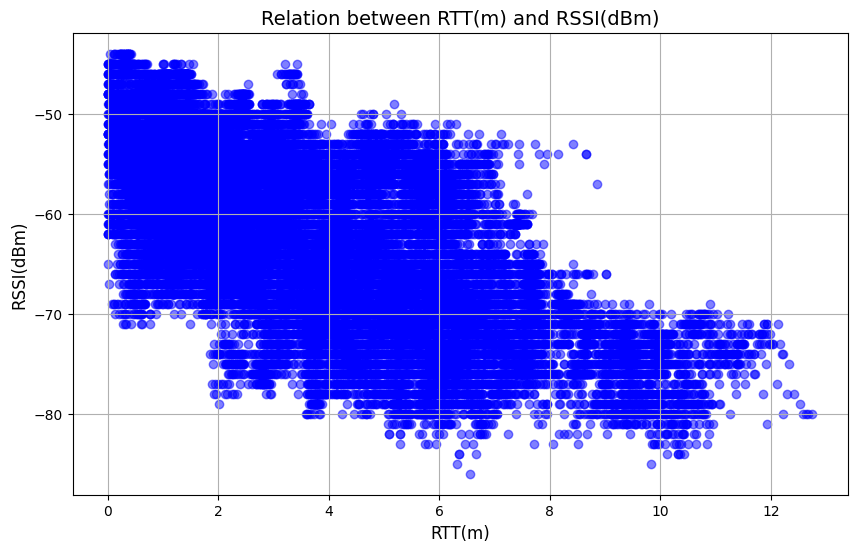

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(wifi_df_sorted['RTT(m)'], wifi_df_sorted['RSSI(dBm)'], color='b', alpha=0.5)

plt.title('Relation between RTT(m) and RSSI(dBm)', fontsize=14)
plt.xlabel('RTT(m)', fontsize=12)
plt.ylabel('RSSI(dBm)', fontsize=12)

plt.grid(True)
plt.show()


Total number of samples: 57890
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


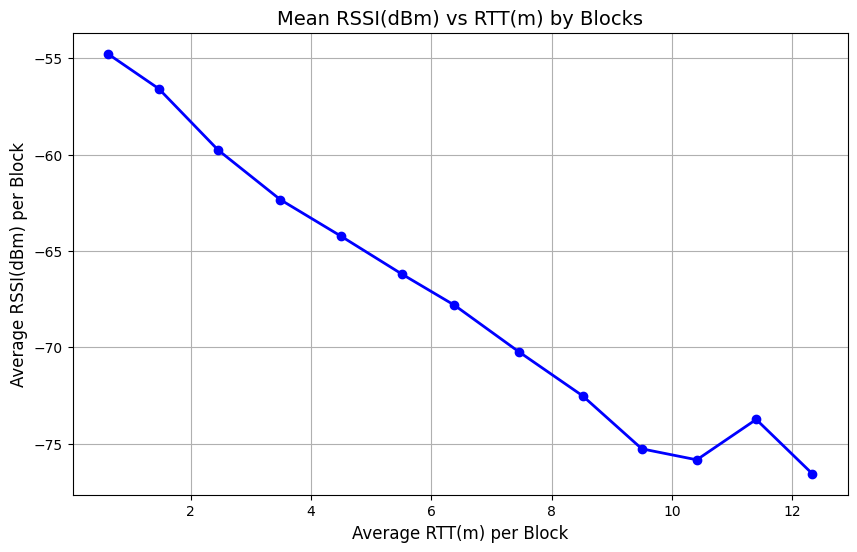

In [ ]:
wifi_df = pd.read_csv("WiFi-RTT-RSS-dataset-main/dataset/rssi_distance.csv")
print("Total number of samples:", len(wifi_df))

wifi_df_sorted = wifi_df.sort_values(by='RTT(m)', ascending=True)


block_size = 1
min_rtt = wifi_df_sorted['RTT(m)'].min()
max_rtt = wifi_df_sorted['RTT(m)'].max()
wifi_df_sorted['block'] = ((wifi_df_sorted['RTT(m)'] - min_rtt) // block_size) + 1

print(wifi_df_sorted['block'].unique())

block_means = wifi_df_sorted.groupby('block').agg({
    'RTT(m)': 'mean', 
    'RSSI(dBm)': 'mean'  
}).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(block_means['RTT(m)'], block_means['RSSI(dBm)'], color='b', marker='o', linestyle='-', linewidth=2)

plt.title('Mean RSSI(dBm) vs RTT(m) by Blocks', fontsize=14)
plt.xlabel('Average RTT(m) per Block', fontsize=12)
plt.ylabel('Average RSSI(dBm) per Block', fontsize=12)

plt.grid(True)
plt.show()


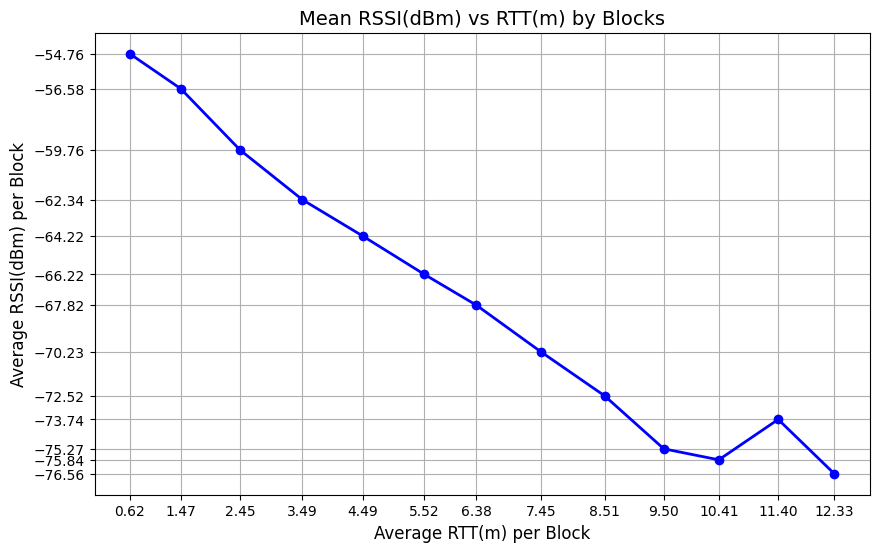

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plotting the line with markers
plt.plot(block_means['RTT(m)'], block_means['RSSI(dBm)'], color='b', marker='o', linestyle='-', linewidth=2)

# Setting ticks to exact data points
plt.xticks(block_means['RTT(m)'], fontsize=10)
plt.yticks(block_means['RSSI(dBm)'], fontsize=10)

# Titles and labels
plt.title('Mean RSSI(dBm) vs RTT(m) by Blocks', fontsize=14)
plt.xlabel('Average RTT(m) per Block', fontsize=12)
plt.ylabel('Average RSSI(dBm) per Block', fontsize=12)

# Adding grid for better readability
plt.grid(True)

# Display the plot
plt.show()


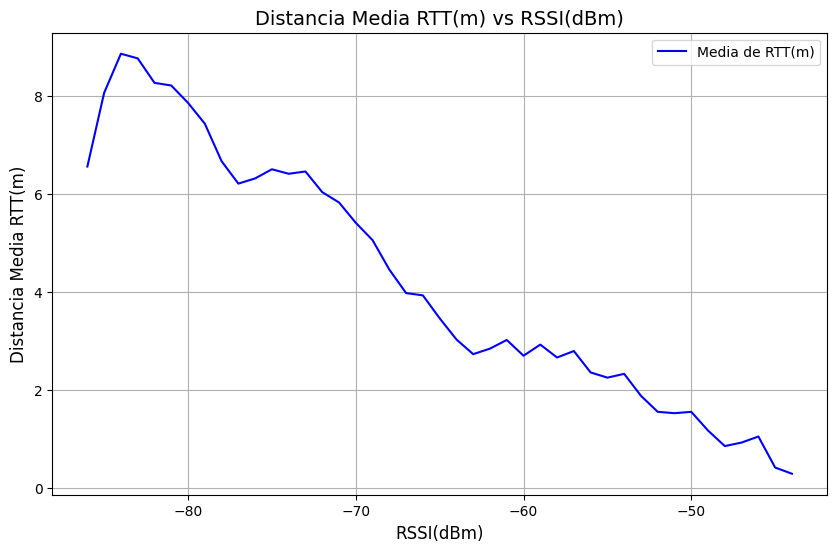

   RSSI(dBm)  mean_rtt  max_rtt  min_rtt   std_rtt
0      -86.0  6.562000    6.562    6.562       NaN
1      -85.0  8.069000    9.825    6.313  2.483359
2      -84.0  8.867875   10.434    6.363  1.994670
3      -83.0  8.772773   10.847    5.288  1.930144
4      -82.0  8.272814   10.873    5.088  1.967023


In [16]:
wifi_df_sorted = wifi_df.sort_values(by="RSSI(dBm)")

agg_stats = wifi_df_sorted.groupby("RSSI(dBm)").agg(
    mean_rtt=("RTT(m)", "mean"),
    max_rtt=("RTT(m)", "max"),
    min_rtt=("RTT(m)", "min"),
    std_rtt=("RTT(m)", "std")
).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(agg_stats["RSSI(dBm)"], agg_stats["mean_rtt"], label="Media de RTT(m)", color='b')
plt.xlabel("RSSI(dBm)", fontsize=12)
plt.ylabel("Distancia Media RTT(m)", fontsize=12)
plt.title("Distancia Media RTT(m) vs RSSI(dBm)", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

print(agg_stats.head())
